In [6]:
CUDA_LAUNCH_BLOCKING="1"

In [7]:
import re
import math
import time
import scipy
import collections
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
# from datasets import load_dataset
from collections import defaultdict
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
# from torcheval.metrics.text import Perplexity

In [9]:
# mode='coding'
mode='training'
if mode =='training':
    corpus_file_path = 'NLP-01-2-HW1-Data/train.txt'
    val_file_path='NLP-01-2-HW1-Data/valid.txt'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    num_epochs = 20
else:
    corpus_file_path = 'NLP-01-2-HW1-Data/test.txt'
    val_file_path='NLP-01-2-HW1-Data/valid.txt'

    # device = 'cpu'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    num_epochs = 2

print(corpus_file_path)

NLP-01-2-HW1-Data/train.txt


In [10]:
available_workers = multiprocessing.cpu_count()
print(f' using {device} with {available_workers} cpus')

 using cuda with 16 cpus


In [11]:
def load_dataset(path):
    with open(path, 'r') as file:
        txt=file.read()
    return txt

In [12]:
def preprocess_txt(txt):
    '''Preprocess the text by removing any unwanted characters,
     converting all the text to lowercase'''
    txt=" ".join(re.findall(r"[\u0600-\u06FF]+", txt)) # delete all non_ persion texts

    # remove any unwanted characters
    txt=txt.replace('\u200c',' ')
    txt=txt.replace('\n',' ')
    txt = re.sub("\d+" ," ", txt)# delete numbers

    txt= re.sub(r'[^\w\s]','',txt)
    # convert all the english text to lowercase
    txt=re.sub(' +', ' ',txt)
    txt=txt.lower()
    
    
    return txt

In [13]:
preprocess_txt('همچنین جمالت فایلهای txt.mask . ۶۷و  hjg txt.incomplete ')

'همچنین جمالت فایلهای و'

In [14]:
def txt2word(txt):
    # split the text into individual words.
    words= txt.split(' ')
    # remove '_' in case it appears individually as a word
    if "_" in words:
        words.remove("_")
    # delete empty strings
    if "" in words:
        words.remove("")
        
    return words

In [15]:
def txt2sentence(txt):
    # split the text into individual sentence.
    sentences=re.split(';|\.|\n|\?|\؟',txt)
    # delete empty strings
    if '' in sentences:
        sentences.remove('')
    
    return sentences

In [17]:
def create_vocab(corpus_txt):
    # create voacab of corpus and delete the low frequent word from it
    words_term_frequency_train={}
    # UNK_symbol = "<UNK>"
    vocab=set()
    words_list = txt2word(corpus_txt)
    # create term frequency of the words
    for word in words_list:
        words_term_frequency_train[word] = words_term_frequency_train.get(word,0) + 1
    # create vocabulary and delete low frequency words
    for word in words_list:
        if words_term_frequency_train.get(word,0) >= 5:
            vocab.add(word)
    return vocab

In [18]:
class CorpusDataset(Dataset):
    def __init__(self, corpus_file_path, vocab,n=2):
        
        self.n=n
        self.corpus =self.load_dataset(corpus_file_path)
        self.corpus=[self.preprocess_txt(sentence) for sentence in self.txt2sentence(self.corpus)]
        self.vocab = vocab
        self.vocab_size=len(vocab)+1
        self.clean_corpus()
        self.word_to_id_mappings=self.create_mapper()
        self.X,self.y=self.create_dataset()



    def create_mapper(self):
        # create dictionary that stores all word and their counts
        word_to_id_mappings={'<UNK>':0}
        for idx, word in enumerate(self.vocab,1):
            word_to_id_mappings[word]=idx
        return word_to_id_mappings

    def word2idx(self,word):
        unknown_word_id = self.word_to_id_mappings['<UNK>']
        return self.word_to_id_mappings.get(word,unknown_word_id)

    def load_dataset(self,path):
        with open(path, 'r') as file:
            txt=file.read()
        return txt

    def preprocess_txt(self,txt):
        '''Preprocess the text by removing any unwanted characters,
        converting all the text to lowercase'''
        # delete all non_ persion texts
        txt=" ".join(re.findall(r"[\u0600-\u06FF]+", txt)) 
        # remove any unwanted characters
        txt=txt.replace('\u200c',' ')
        txt=txt.replace('\n',' ')
        txt = re.sub("\d+" ," ", txt)# delete numbers
        txt= re.sub(r'[^\w\s]','',txt)
        # convert all the english text to lowercase
        txt=re.sub(' +', ' ',txt)
        # convert all the english text to lowercase
        txt=txt.lower()  
        return txt

    def txt2sentence(self,txt):
        # split the text into individual sentence.
        sentences=re.split(';|\.|\n|\?|\؟',txt)
        # delete empty strings
        sentences=list (filter(lambda sent : sent!= '', sentences))
        
        return sentences
        
    
    def clean_corpus(self):
        self.corpus=list (filter(lambda sentence : sentence!= '', self.corpus))


    def txt2word(self,txt):
        # split the text into individual words.
        words= txt.split(' ')
        # remove '_' in case it appears individually as a word
        if "_" in words:
            words.remove("_")
        # delete empty strings
        if "" in words:
            words.remove("")
            
        return words
    

    def create_dataset(self):
        X=[]
        y=[]
        for sentence in self.corpus:
            words_list=self.txt2word(sentence)
            for i in range(len(words_list)):
                if len(words_list)<= i+self.n:
                    # ignoring sentece less than contex size 
                    # (if n=3 less than 4 words )
                    break
                
                x_extract=[self.word2idx(words_list[i+j]) for j in range(self.n) ]
                y_extraxt=[self.word2idx(words_list[i+self.n])]
                # for n=3 x is[i,i+1,i+2]
                # and y is [i+3]
                
                X.append(x_extract)
                y.append(y_extraxt)
        
        return np.array(X),np.array(y)



    def __getitem__(self, idx):
        
        x_1 = torch.from_numpy(self.X[idx]).to(device)
        y_1 = torch.tensor(self.y[idx]).to(device)
        return x_1,y_1
        
    
    def __len__(self):
        return len(self.X)




In [26]:
class FFNNLanguageModel(nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_dim,n=2):
        ''' output_dim=vocab_size
        n : N previous word that we want to predict based on them (input context_size)
        '''
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embedding=nn.Embedding(vocab_size, embedding_dim)# embeding layer E(V*d)
        self.hidden_layer=nn.Linear(n*embedding_dim, hidden_dim)# hidden layer W(nd*d_h)
        self.output_layer=nn.Linear(hidden_dim, vocab_size,bias = False)# output layer U (d_h*V)
        self.n=n #input context_size
    def forward(self,x):
 
        # compute X : v*nd  if n=3 it will concatinate X1,X2,X3 for trigram model
        embedded = self.embedding(x).view((-1,self.n * self.embedding_dim))
        # compute  hidden layer
        hidden = F.relu(self.hidden_layer(embedded))
        # compute softmax of output
        output = F.softmax(self.output_layer(hidden), dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return output

In [69]:
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

In [70]:
def plot_charts(train_losses,train_accu):
    # plot accuracy and loss chart
    fig = plt.figure()
    plt.plot(list(range(num_epochs)), train_losses, color='blue')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('epochs')
    plt.ylabel('negative log likelihood loss')
    plt.savefig("loss.png")
    plt.show()

    fig = plt.figure()
    plt.plot(list(range(num_epochs)), train_accu, color='blue')
    plt.legend(['Train accuracy'], loc='upper right')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.savefig("loss.png")
    plt.show()


In [71]:

def train_model(data_loader,model,criterion,optimizer,num_epochs):
    train_losses = []
    train_accu=[]
    for epoch in range(num_epochs):
        running_loss = 0
        st = time.time()
        for i, (inputs, labels) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs)

            acc = get_accuracy_from_log_probs(outputs, labels)
            
            loss = criterion(outputs,labels.squeeze())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 0: 
                print("Training Iteration {} of epoch {}  Loss: {}; Acc:{}; Time taken (s): {}".format(
                    i, epoch, loss.item(), acc, (time.time()-st)))
                st = time.time()
        train_losses.append(running_loss/len(data_loader))
        train_accu.append((100*acc.cpu().numpy()))
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/i:.4f},acc: {acc}')
    return model,train_losses,train_accu

# trigram NN model


In [23]:
context_size=3

## create vocab

In [19]:
train_corpus=load_dataset(corpus_file_path)
train_preprocess_corpus=preprocess_txt(train_corpus)
# train_vocab=create_vocab(train_corpus)
vocab= create_vocab(train_corpus)

In [20]:
val_corpus=load_dataset(val_file_path)
val_preprocess_corpus=preprocess_txt(train_corpus)

# set up model

In [21]:
embedding_dim = 200#len(train_dense_embed)
hidden_dim = 100
vocab_size = len(vocab)+1

# laod data and create trigram

In [24]:
dataset = CorpusDataset(corpus_file_path, vocab, n=context_size)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
val_dataset = CorpusDataset(corpus_file_path, vocab, n=context_size)
val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [78]:
# instantiate the model, loss function, and optimizer
model = FFNNLanguageModel(vocab_size, embedding_dim, hidden_dim,n=context_size).to(device)
criterion = nn.CrossEntropyLoss()
# criterion=nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# train and test the model

In [79]:
model,train_losses,train_accu=train_model(data_loader,model,criterion,optimizer,num_epochs)


Training Iteration 0 of epoch 0  Loss: 8.904497146606445; Acc:0.0; Time taken (s): 0.014261722564697266
Training Iteration 1000 of epoch 0  Loss: 8.84222412109375; Acc:0.0625; Time taken (s): 2.2114715576171875
Training Iteration 2000 of epoch 0  Loss: 8.842225074768066; Acc:0.0625; Time taken (s): 2.1767807006835938
Training Iteration 3000 of epoch 0  Loss: 8.87347412109375; Acc:0.03125; Time taken (s): 2.2114741802215576
Training Iteration 4000 of epoch 0  Loss: 8.654725074768066; Acc:0.236328125; Time taken (s): 2.171353340148926
Training Iteration 5000 of epoch 0  Loss: 8.748475074768066; Acc:0.1484375; Time taken (s): 2.1774001121520996
Training Iteration 6000 of epoch 0  Loss: 8.779725074768066; Acc:0.125; Time taken (s): 2.1834452152252197
Training Iteration 7000 of epoch 0  Loss: 8.779376029968262; Acc:0.150390625; Time taken (s): 2.225490093231201
Training Iteration 8000 of epoch 0  Loss: 8.842225074768066; Acc:0.0625; Time taken (s): 2.174515724182129
Training Iteration 9000 

In [80]:
torch.save(model, f'./FFLM_{num_epochs}_{context_size}gram.pth')

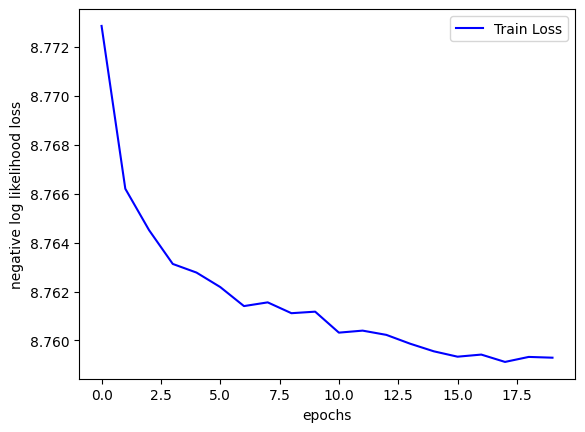

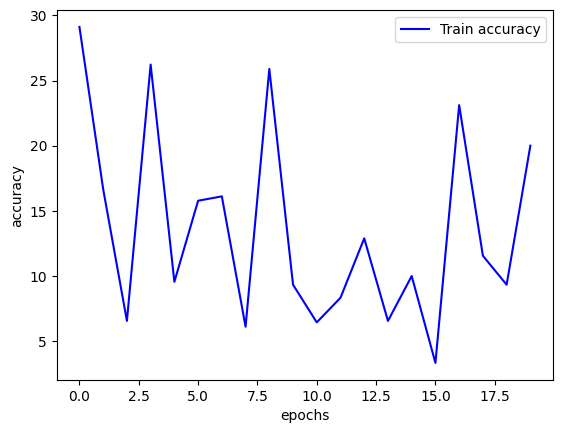

In [81]:
plot_charts(train_losses,train_accu)

In [36]:
model=torch.load('./FFLM_20_3gram.pth')


In [ ]:
num_batches = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_data_loader):
        # Get predictions from the model
        outputs = model(inputs)
        # Compute the loss
        loss = F.cross_entropy(outputs, labels.view(-1))
        total_loss += loss.item()
        num_batches += 1

In [ ]:
perplexity = torch.exp(torch.tensor(total_loss / num_batches))

In [ ]:
perplexity

tensor(6530.5562)

# bigram NN model

In [38]:
context_size=2

In [44]:
dataset = CorpusDataset(corpus_file_path, vocab, n=context_size)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [45]:
val_dataset = CorpusDataset(corpus_file_path, vocab, n=context_size)
val_data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [87]:
# instantiate the model, loss function, and optimizer
model = FFNNLanguageModel(vocab_size, embedding_dim, hidden_dim,n=context_size).to(device)
criterion = nn.CrossEntropyLoss()
# criterion=nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [88]:
model,train_losses,train_accu=train_model(data_loader,model,criterion,optimizer,num_epochs)


Training Iteration 0 of epoch 0  Loss: 8.904492378234863; Acc:0.0; Time taken (s): 0.013465404510498047
Training Iteration 1000 of epoch 0  Loss: 8.685979843139648; Acc:0.1826171875; Time taken (s): 2.661414384841919
Training Iteration 2000 of epoch 0  Loss: 8.656073570251465; Acc:0.17578125; Time taken (s): 3.06241774559021
Training Iteration 3000 of epoch 0  Loss: 8.700812339782715; Acc:0.1826171875; Time taken (s): 2.2853147983551025
Training Iteration 4000 of epoch 0  Loss: 8.842225074768066; Acc:0.0625; Time taken (s): 4.590579032897949
Training Iteration 5000 of epoch 0  Loss: 8.717225074768066; Acc:0.1826171875; Time taken (s): 2.8957433700561523
Training Iteration 6000 of epoch 0  Loss: 8.685973167419434; Acc:0.203125; Time taken (s): 2.2147727012634277
Training Iteration 7000 of epoch 0  Loss: 8.842225074768066; Acc:0.0615234375; Time taken (s): 2.180947780609131
Training Iteration 8000 of epoch 0  Loss: 8.779725074768066; Acc:0.125; Time taken (s): 2.231170892715454
Training 

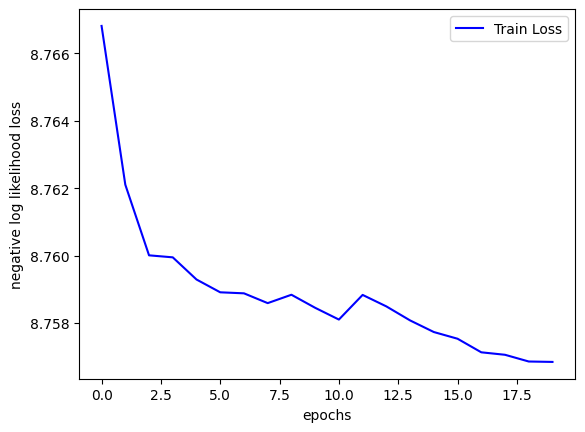

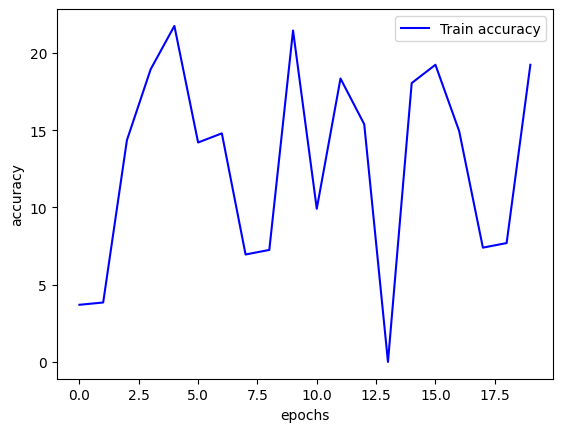

In [89]:
torch.save(model, f'./FFLM_{num_epochs}_{context_size}gram.pth')
plot_charts(train_losses,train_accu)


In [42]:
model=torch.load('./FFLM_20_2gram.pth')


In [46]:
num_batches = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_data_loader):
        # Get predictions from the model
        outputs = model(inputs)
        # Compute the loss
        loss = F.cross_entropy(outputs, labels.view(-1))
        total_loss += loss.item()
        num_batches += 1

In [47]:
perplexity = torch.exp(torch.tensor(total_loss / num_batches))

In [48]:
perplexity

tensor(8.4319e+08)